# Прикладная аналитика. Задание к лекции 5. Фабарисов Дмитрий

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import copy
import pickle
import scipy as sp
from scipy.stats import mannwhitneyu as MW
from scipy.stats import kstest, ks_2samp
from scipy.stats import expon
from sklearn.cross_validation import train_test_split as Splitter
%matplotlib inline

## 1. Подготовка данных и разделение на экспериментальную  и контрольную выборки

Перед запуском ноутбука запустили скрипт, который удалил все названия параметров, потому что иначе чтение слишком долгое

In [42]:
data = pd.read_csv('log.new.csv', sep='\t')
data.head()

,slot,userID,ts,browser,all_cl
0,1,1,2016-03-03,2,1
1,1,1,2016-03-03,2,5
2,1,1,2016-03-03,2,1
3,1,1,2016-03-03,2,1
4,1,1,2016-03-03,2,6


In [43]:
data_contr = data[data['slot'] == 0]
data_exp = data[data['slot'] == 1]
userIDs = data['userID'].unique()
controlIDs = data_contr['userID'].unique()
expIDs = data_exp['userID'].unique()

## 2. Подсчет метрик количества кликов, CTR, числа запросов

In [44]:
def clicks(data):
    mat = data.as_matrix()
    res = np.zeros(max(userIDs) + 1)
    
    for line in range(len(data)):
        user = mat[line, 1]
        res[user] += mat[line, 4]
        
    return res

In [45]:
def ctr(data):
    mat = data.as_matrix()
    clicks = np.zeros(max(userIDs) + 1)
    shows = np.zeros(max(userIDs) + 1)
    res = np.zeros(max(userIDs) + 1)
    
    for line in range(len(data)):
        user = mat[line, 1]
        clicks[user] += mat[line, 4]
        shows[user] += 1
    
    for user in range(len(res)):
        if clicks[user] != 0:
            res[user] = float(clicks[user]) / shows[user]
    
    return res

In [46]:
def queries_count(data):
    mat = data.as_matrix()
    res = np.zeros(max(userIDs) + 1)
    
    for line in range(len(data)):
        user = mat[line, 1]
        res[user] += 1
        
    return res

In [47]:
def clicked_queries(data):
    mat = data.as_matrix()
    shows = np.zeros(max(userIDs) + 1)
    clicked = np.zeros(max(userIDs) + 1)
    res = np.zeros(max(userIDs) + 1)
    clicked_ind = np.array(mat[:, 4] > 0, dtype=int)

    for line in range(len(data)):        
        user = mat[line, 1]
        shows[user] += 1
        clicked[user] += clicked_ind[line]

    for user in range(len(res)):
        if shows[user] != 0:
            res[user] = float(clicked[user]) / shows[user]

    return res

In [48]:
clicks_array = clicks(data)
ctr_array = ctr(data)
queries_count_array = queries_count(data)
clicked_queries_array = clicked_queries(data)

In [49]:
clicks_contr = []
clicks_exp = []
qc_contr = []
qc_exp = []
ctr_contr = []
ctr_exp = []
cq_contr = []
cq_exp = []

for user in controlIDs:
    clicks_contr.append(clicks_array[user])
    ctr_contr.append(ctr_array[user])
    qc_contr.append(queries_count_array[user])
    cq_contr.append(clicked_queries_array[user])

for user in expIDs:
    clicks_exp.append(clicks_array[user])
    ctr_exp.append(ctr_array[user])
    qc_exp.append(queries_count_array[user])
    cq_exp.append(clicked_queries_array[user])

## 3. Подсчет статистик и уровней значимости

Прежде, чем применять статистические тесты посмотрим на данные: гистограммы распределения CTR для контрольной и экспериментальной выборок

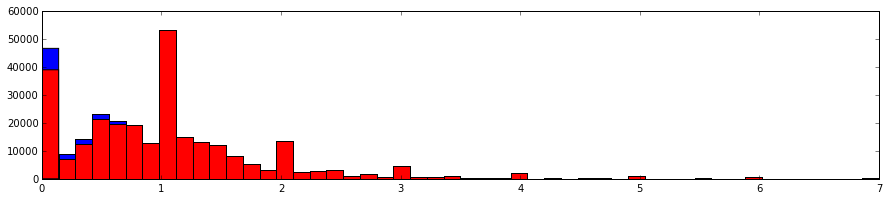

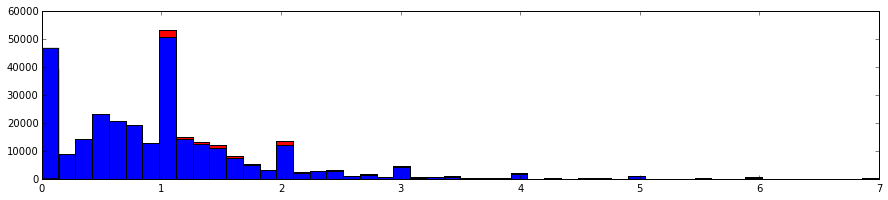

In [50]:
fig = plt.figure(figsize=(15, 3))
_ = plt.hist(ctr_contr, bins=50, range=(0, 7), color='blue')
_ = plt.hist(ctr_exp, bins=50, range=(0, 7), color='red')

fig = plt.figure(figsize=(15, 3))
_ = plt.hist(ctr_exp, bins=50, range=(0, 7), color='red')
_ = plt.hist(ctr_contr, bins=50, range=(0, 7), color='blue')

### Вывод про CTR:
-Виден ожидаемый прирост CTR на экспериментальных данных.  
-Распределение не похоже на нормальное, поэтому  
1. Не рекомендуется пользоваться тестами Стьюдента, Вальда  
2. Будем использовать критерии Манна — Уитни и Колмогорова-Смирнова

In [51]:
print MW(ctr_contr, ctr_exp)
print ks_2samp(ctr_contr, ctr_exp)

MannwhitneyuResult(statistic=37725155448.0, pvalue=5.7215385393095495e-306)
Ks_2sampResult(statistic=0.045118104880379484, pvalue=1.0621277092100762e-250)


#### Оба теста показали достаточный уровень значимости, чтобы утверждать, что выборки различны, притом так, как нужно

### Аналогично поступим с количеством кликов

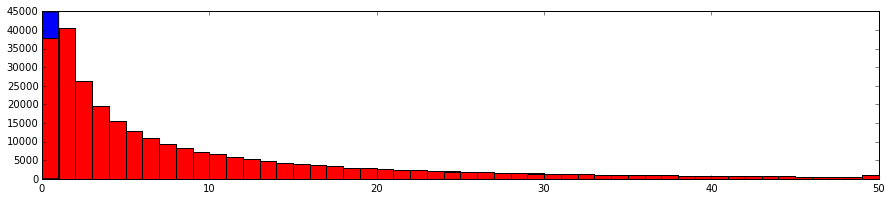

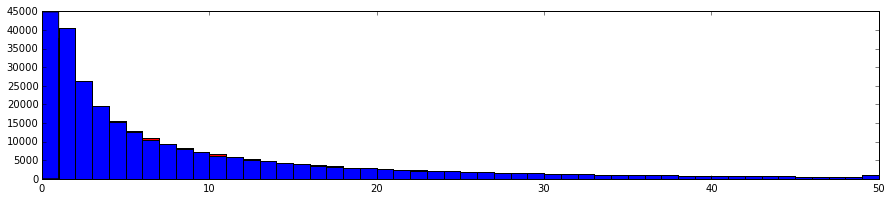

In [52]:
fig = plt.figure(figsize=(15, 3))
_ = plt.hist(clicks_contr, bins=50, range=(0, 50), color='blue')
_ = plt.hist(clicks_exp, bins=50, range=(0, 50), color='red')

fig = plt.figure(figsize=(15, 3))
_ = plt.hist(clicks_exp, bins=50, range=(0, 50), color='red')
_ = plt.hist(clicks_contr, bins=50, range=(0, 50), color='blue')

Гистограммы имеют ожидаемый вид, распределение тоже явно не нормальное, проверим гипотезу на экспоненциальность распределения

In [53]:
print kstest(clicks_contr, 'expon')

KstestResult(statistic=0.56397412068473529, pvalue=0.0)


Гипотеза отвергается, поэтому будем использовать те же тесты, что и для CTR метрики.

In [54]:
print MW(clicks_contr, clicks_exp)
print ks_2samp(clicks_contr, clicks_exp)

MannwhitneyuResult(statistic=38901259929.0, pvalue=1.5633428851312857e-74)
Ks_2sampResult(statistic=0.023833024410180481, pvalue=2.9236023409457489e-70)


Снова получаем значимое влияние на пользователей

### Проверим, что внутри контрольной группы выполняется гипотеза, что контрольная группа из единого распределения (проверка, что тесты работают корректно)
Для этого разделим выборку на две равные части и применим критерий Колмогорова-Смирнова. Ожидаем p-value > 0.05

In [55]:
part1, part2 = Splitter(clicks_contr, test_size=0.5)
ks_2samp(part1, part2)

Ks_2sampResult(statistic=0.0037483473515429466, pvalue=0.2700870557705416)

## 4. Срезы и локализации

Предполагаем, что в некоторых браузерах эффект был значимый в некоторых нет, поэтому протестируем гипотезы для каждого браузера

In [58]:
browsers= np.zeros(max(userIDs) + 1)
matr = data.as_matrix()
for line in range(len(data)):
    browsers[matr[line, 1]] = matr[line, 3]
browsers_unique = data['browser'].unique()
user_contr = pd.DataFrame({'userID':controlIDs, 
                           'clicks':clicks_contr,
                           'ctr':ctr_contr, 
                           'qc':qc_contr,
                           'cq':cq_contr,
                           'browser':[browsers[user] for user in controlIDs]})
user_exp = pd.DataFrame({'userID':expIDs, 
                         'clicks':clicks_exp, 
                         'ctr':ctr_exp, 
                         'qc':qc_exp,
                         'cq':cq_exp,
                         'browser':[browsers[user] for user in expIDs]})
for browser in browsers_unique:
    print "p-value for browser", browser, ": ", MW(user_contr[user_contr['browser'] == browser]['clicks'], 
             user_exp[user_exp['browser'] == browser]['clicks'])[1]

p-value for browser 2 :  0.0310253303759
p-value for browser 4 :  0.407784444038
p-value for browser 14 :  0.0
p-value for browser 17 :  0.0364582057965
p-value for browser 20 :  0.454170826021
p-value for browser 22 :  0.258927519107


### Вывод: для 14 браузера бесспорно изменение значимо, также эффект заметен для 2 и 17. На остальных браузерах особого влияния не наблюдается.

## 5. Положительный или отрицательный эффект имело экспериментальное изменение?

### 5.1 Будем действовать следующим образом:  
1. Посмотрим на значимость браузеров (какая доля запросов приходится именно на данный браузер)  
2. Определим значимость 14 браузера  
3. Посмотрим, не изменилось ли число запросов в целом  
4. Сформулируем дальнейший план действий

In [59]:
total_qc = np.sum(user_contr['qc']) + np.sum(user_exp['qc'])
for browser in browsers_unique:
    br_sum = np.sum(user_contr[user_contr['browser'] == browser]['qc']) +np.sum(user_exp[user_exp['browser'] == browser]['qc'])
    print "browser ", browser, ": ", round(1.0 * br_sum / total_qc, 3) * 100, "%"

browser  2 :  18.4 %
browser  4 :  34.1 %
browser  14 :  9.3 %
browser  17 :  6.9 %
browser  20 :  6.3 %
browser  22 :  25.1 %


Волшебный 14 браузер хоть и занимает всего 10% рынка, не может оказывать пренебрежимо малое влияние

In [60]:
for browser in browsers_unique:
    MW_mean = (len(user_contr[user_contr['browser'] == browser]) * len(user_exp[user_exp['browser'] == browser])) / 2.0
    MW_stat, p_value = MW(user_contr[user_contr['browser'] == browser]['qc'], user_exp[user_exp['browser'] == browser]['qc'])
    print 'browser', browser, ':'
    print 'delta = ', (MW_mean - MW_stat)/MW_mean, ' p_value = ', p_value

browser 2 :
delta =  0.000620737457456  p_value =  0.429056324506
browser 4 :
delta =  0.0143097716411  p_value =  4.60745874411e-07
browser 14 :
delta =  0.00927730450803  p_value =  0.00823288678929
browser 17 :
delta =  0.00778866802758  p_value =  0.111621420351
browser 20 :
delta =  0.00990272373838  p_value =  0.0571003392158
browser 22 :
delta =  0.00686874797676  p_value =  0.0123045080401


По некоторым браузерам число запросов в целом значимо снизилось, что является негативным эффектом. Попробуем все же разобраться с 14 браузером

### 5.2 Выводы
Существенные различия в значимости браузеров заставляют задуматься над тем, насколько качественно оценивают ситуацию абсолютные метрики. Хочется перейти к относительным статистикам (CTR или доля кликнутых запросов) и далее говорить о важности результатов по каждому браузеру. Дальнейший план:  
5. Посмотреть на CTR по браузерам и его изменение  
6. Посмотреть на долю кликнутых запросов по браузерам и её изменение

### CTR

In [61]:
for browser in browsers_unique:
    contr_ctr = np.mean(user_contr[user_contr['browser'] == browser]['ctr'])
    exp_ctr = np.mean(user_exp[user_exp['browser'] == browser]['ctr'])
    delta = exp_ctr - contr_ctr
    print "browser ", browser, ": ", "control CTR: ", contr_ctr, "    exp CTR", exp_ctr, "    delta: ", delta

browser  2 :  control CTR:  0.967047350712     exp CTR 0.984332287468     delta:  0.0172849367553
browser  4 :  control CTR:  1.03026329767     exp CTR 1.06432446335     delta:  0.0340611656773
browser  14 :  control CTR:  0.647257474415     exp CTR 1.01181070999     delta:  0.364553235575
browser  17 :  control CTR:  1.23659607634     exp CTR 1.2696358493     delta:  0.0330397729614
browser  20 :  control CTR:  1.18473868652     exp CTR 1.19159179553     delta:  0.00685310900802
browser  22 :  control CTR:  1.13917160425     exp CTR 1.14951210253     delta:  0.0103404982804


Кажется виден прогресс: на контрольной группе в 14 браузере CTR был плачевно мал по сравнению с остальными браузерами, теперь в экспериментальной наш волшебный браузер перестал так выбиваться.  
Скорее всего исправлены ошибки и это дало положительный эффект

### Число кликнутых запросов

In [62]:
for browser in browsers_unique:
    contr_cq = np.mean(user_contr[user_contr['browser'] == browser]['cq'])
    exp_cq = np.mean(user_exp[user_exp['browser'] == browser]['cq'])
    delta = exp_cq - contr_cq
    print "browser ", browser, ": ", "control click count: ", contr_cq, "    exp click count", exp_cq, "    delta: ", delta

browser  2 :  control click count:  0.535870877325     exp click count 0.544600902702     delta:  0.00873002537764
browser  4 :  control click count:  0.555237743254     exp click count 0.569918509873     delta:  0.0146807666191
browser  14 :  control click count:  0.39926135763     exp click count 0.568942856231     delta:  0.1696814986
browser  17 :  control click count:  0.632474981935     exp click count 0.633432429595     delta:  0.000957447659968
browser  20 :  control click count:  0.609228131835     exp click count 0.621389999608     delta:  0.0121618677728
browser  22 :  control click count:  0.605558524386     exp click count 0.609174187141     delta:  0.00361566275562


После того, что мы знаем о существенном росте CTR для 14 браузера не удивителен  также рост числа кликнутых запросов.

## 6. Итоговый вывод
Скорее всего интегральный рост числа кликов, вызванный ростом числа кликов на 14 браузере обусловлен тем, что этот самый браузер был улучшен. А говоря точнее, не улучшен, а починен, т.к. раньше он был хуже остальных, а теперь держится на уровне.